After Ordered Transformation PR

https://discourse.pymc.io/t/sampling-uniformly-in-a-triangular-support/765/

In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano
import seaborn as sns
import pystan

%pylab inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
class Chained(pm.distributions.transforms.Transform):
    def __init__(self, transform_list):
        self.transform_list = transform_list
        self.name = '_'.join([transf.name for transf in self.transform_list])

    def forward(self, x):
        y = x
        for transf in self.transform_list:
            y = transf.forward(y)
        return y

    def forward_val(self, x, point=None):
        y = x
        for transf in self.transform_list:
            y = transf.forward_val(y)
        return y

    def backward(self, y):
        x = y
        for transf in reversed(self.transform_list):
            x = transf.backward(x)
        return x

    def jacobian_det(self, y):
        det_list = []
        for transf in reversed(self.transform_list):
            det_list.append(transf.jacobian_det(y))
            y = transf.backward(y)
        # match the shape of the first jacobian_det
        det = 0.
        ndim0 = det_list[0].ndim
        for det_ in det_list:
            if det_.ndim > ndim0:
                det += det_.sum(axis=-1)
            else:
                det += det_
        return det

In [3]:
Order = pm.distributions.transforms.Ordered()
upper, lower = 0., 1.
Interval = pm.distributions.transforms.Interval(upper, lower)
Logodd = pm.distributions.transforms.LogOdds()
chain_tran = Chained([Logodd, Order])

In [4]:
with pm.Model() as m2:
    x = pm.Uniform('x', 0., 1., shape=2,
                   transform=chain_tran,
                   testval=[0.1, 0.9])
    pm.Deterministic('jacobian', chain_tran.jacobian_det(chain_tran.forward(x)))
    
    tr2 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_logodds_ordered__]
INFO:pymc3:NUTS: [x_logodds_ordered__]
100%|██████████| 6000/6000 [00:05<00:00, 1184.17it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '13302' (I am process '13303')
INFO:theano.gof.compilelock:Waiting for existing lock by process '13302' (I am process '13303')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process 

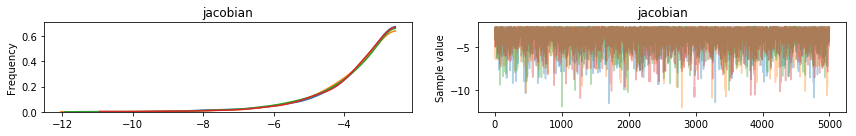

In [5]:
varnames = tr2.varnames
pm.traceplot(tr2, varnames=['jacobian']);

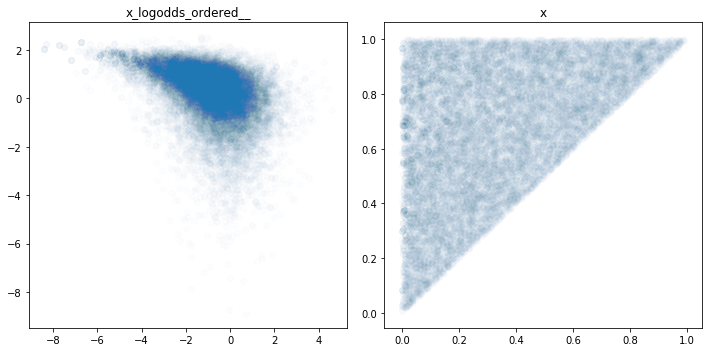

In [6]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(tr2[varname][:, 0], tr2[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

In [7]:
shape = (4, 2)
testval = np.random.rand(*shape)
testval = np.sort(testval/testval.sum(axis=-1, keepdims=True))
testval

array([[0.41228708, 0.58771292],
       [0.04504089, 0.95495911],
       [0.43642114, 0.56357886],
       [0.45405477, 0.54594523]])

In [8]:
with pm.Model() as m2:
    x = pm.Normal('x', 0., 1., shape=shape,
                   transform=Order,
                   testval=testval)
    
    tr2 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_ordered__]
INFO:pymc3:NUTS: [x_ordered__]
100%|██████████| 6000/6000 [00:10<00:00, 550.66it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
factors = [var.logpt for var in m2.basic_RVs] + m2.potentials
func1 = theano.function(m2.basic_RVs, factors)
func1(Order.forward_val(testval))

[array(-14.85676742)]

In [10]:
m2.logp(m2.test_point)

array(-14.85676742)

In [11]:
x0 = m2.basic_RVs[0]
x0.distribution.logp(Order.forward_val(testval)).eval()

array([-3.83610954, -2.38926541, -4.15424645, -4.47714602])

In [12]:
x = Order.forward_val(testval)
x0.distribution.logp_nojac(x).eval()

array([[-1.00392885, -1.09164177],
       [-0.91995287, -1.37491198],
       [-1.01417024, -1.0777491 ],
       [-1.0220214 , -1.06796663]])

In [13]:
x0.distribution.transform_used.jacobian_det(x).eval()

array([-1.74053891, -0.09440056, -2.06232711, -2.38715799])

In [14]:
(x0.distribution.logp_nojac(x).sum(axis=-1) + x0.distribution.transform_used.jacobian_det(x)).eval()

array([-3.83610954, -2.38926541, -4.15424645, -4.47714602])

In [15]:
tt.sum(x0.distribution.logp_nojac(x).sum(axis=-1) + x0.distribution.transform_used.jacobian_det(x)).eval()

array(-14.85676742)

In [19]:
with pm.Model() as m2:
    x = pm.Uniform('x', 0., 1., shape=shape,
                   transform=chain_tran,
                   testval=testval)
    pm.Deterministic('jacobian', chain_tran.jacobian_det(chain_tran.forward(x)))
    
    tr2 = pm.sample(2500, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_logodds_ordered__]
INFO:pymc3:NUTS: [x_logodds_ordered__]
100%|██████████| 3500/3500 [00:06<00:00, 580.57it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [20]:
post_x = tr2['x']

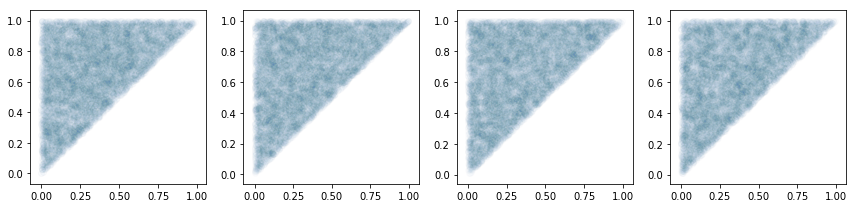

In [21]:
_, ax = plt.subplots(1, 4, figsize=(12, 3))
for ivar in range(shape[0]):
    ax[ivar].scatter(post_x[:, ivar, 0], post_x[:, ivar, 1], alpha=.01)
plt.tight_layout();